# Slip on Grass Example
This notebook contains a toy example model for reasoning about the probability of slipping and getting injured on grass.
We first create the prior and conditional factors and then use these factors to construct a cluster graph. We then use this graph to perform
inference.

In [1]:
import sys
sys.path.append('../')

In [2]:
from veroku.factors.categorical import Categorical, CategoricalTemplate
from veroku.cluster_graph import ClusterGraph
import numpy as np

In [3]:
all_factors = []

### 1. Factor Specification
In this section we specify the prior and conditional distributions that will define our graph (and joint distribution).

#### 1.1 Priors

In [4]:
from veroku.factors.sparse_categorical import SparseCategorical
var_names = ['rain']
probs_table = {(0,):0.8, # no rain
               (1,):0.2} #    rain
var_cardinalities = [2]

SparseCategorical(probs_table=probs_table,
                  var_names=var_names,
                  cardinalities=var_cardinalities)

rain	prob
0	0.8000
1	0.2000

In [5]:
var_names = ['rain']
probs_table = {(0,):0.8, # no rain
               (1,):0.2} #    rain
var_cardinalities = [2]

rain_proir_pd = Categorical(probs_table=probs_table,
                            var_names=var_names,
                            cardinalities=var_cardinalities)
all_factors.append(rain_proir_pd)
rain_proir_pd.show()

rain	prob
0	0.8000
1	0.2000



In [6]:
var_names = ['sprinklers']
probs_table = {(0,):0.2, # no rain
               (1,):0.8} #    rain
var_cardinalities = [2]

sprinkers_proir_pd = Categorical(probs_table=probs_table,
                                 var_names=var_names,
                                 cardinalities=var_cardinalities)
all_factors.append(sprinkers_proir_pd)
sprinkers_proir_pd.show()

sprinklers	prob
0		0.2000
1		0.8000



In [7]:
rain_proir_pd.absorb(sprinkers_proir_pd).show()

sprinklers	rain	prob
0		0	0.1600
0		1	0.0400
1		0	0.6400
1		1	0.1600



#### 1.2 Conditional Probability Distributions

In [8]:
var_names = ['rain', 'sprinklers', 'wet_grass']
probs_table = {(0,0,0):0.90, # grass dry given no rain and sprinklers off
               (0,0,1):0.10, # grass wet given "
               (0,1,0):0.05, # grass dry given no rain and sprinklers on
               (0,1,1):0.95, # grass wet given "
               (1,0,0):0.20, # grass dry given    rain and sprinklers off
               (1,0,1):0.80, # grass wet given "
               (1,1,0):0.00, # grass dry given    rain and sprinklers on
               (1,1,1):1.00} # grass wet given "
var_cardinalities = [2,2,2]

wet_grass_given_rain_and_sprinklers_cpd = Categorical(probs_table=probs_table,
                                                      var_names=var_names,
                                                      cardinalities=var_cardinalities)
all_factors.append(wet_grass_given_rain_and_sprinklers_cpd)
wet_grass_given_rain_and_sprinklers_cpd.show()

rain	sprinklers	wet_grass	prob
0	0		0		0.9000
0	0		1		0.1000
0	1		0		0.0500
0	1		1		0.9500
1	0		0		0.2000
1	0		1		0.8000
1	1		0		0.0000
1	1		1		1.0000



In [9]:
var_names = ['wet_grass','slip']
probs_table = {(0,0):0.2, #no slip given no wet_grass
               (0,1):0.8, #   slip given no wet_grass
               (1,0):0.6, #no slip given    wet_grass
               (1,1):0.4} #   slip given    wet_grass
var_cardinalities = [2,2]

slip_given_rain_cpd = Categorical(probs_table=probs_table,
                                  var_names=var_names,
                                  cardinalities=var_cardinalities)
all_factors.append(slip_given_rain_cpd)
slip_given_rain_cpd.show()

wet_grass	slip	prob
0		0	0.2000
0		1	0.8000
1		0	0.6000
1		1	0.4000



In [10]:
var_names = ['slip','injury']
probs_table = {(0,0):0.9, #no injury given no slip
               (0,1):0.1, #   injury given no slip
               (1,0):0.2, #no injury given    slip
               (1,1):0.8} #   injury given    slip
var_cardinalities = [2,2]

injury_given_slip_cpd = Categorical(probs_table=probs_table,
                                    var_names=var_names,
                                    cardinalities=var_cardinalities)
all_factors.append(injury_given_slip_cpd)
injury_given_slip_cpd.show()

slip	injury	prob
0	0	0.9000
0	1	0.1000
1	0	0.2000
1	1	0.8000



### 2. Cluster Graph Inference
In this section we use the distributions specified in the previous section to build a cluster graph and run message passing inference in this graph to get the posterior marginal distribution over the event of slipping on the grass.

In [11]:
observed_evidence = {'rain':1}
marginal_vrs = ['slip']

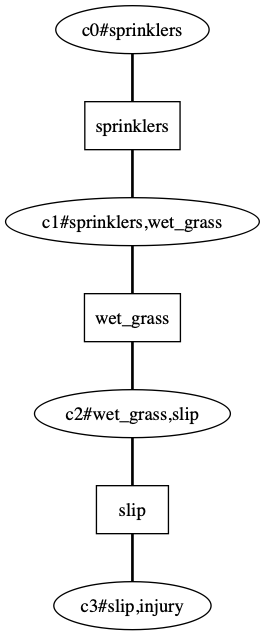

In [12]:
cluster_graph = ClusterGraph(all_factors, observed_evidence)
cluster_graph.debug = True
cluster_graph.show()

In [13]:
cluster_graph._clusters[1]._factor.show()

sprinklers	wet_grass	prob
0		0		0.2000
0		1		0.8000
1		0		0.0000
1		1		1.0000



In [14]:
cluster_graph.process_graph(tol=0.01, max_iter=10)

In [15]:
slip_posterior = cluster_graph.get_marginal(vrs=marginal_vrs)
slip_posterior.normalize().show()

slip	prob
0	0.5840
1	0.4160



### 3.0 Without a Cluster Graph
We can of course also compute marginal distributions without using a cluster graph by simply multipying all the factors together, observing variables and reducing the joint distribution (with the given evvidence) and then marginalising
out the variables that we are not interested in. While this approach works well enough for small examples, it is often intractable when the number of factors become large - since this causes a combinatoric increase in the parameters of the joint distribution.

In [16]:
joint_distribution = all_factors[0]
for factor in all_factors[1:]:
    joint_distribution = joint_distribution.absorb(factor)

reduced_distribution = joint_distribution.reduce(vrs=list(observed_evidence.keys()),
                                                 values=list(observed_evidence.values()))
marginal_posterior = reduced_distribution.marginalize(vrs=marginal_vrs, keep=True)#.normalize()
marginal_posterior.normalize().show()

slip	prob
0	0.5840
1	0.4160



In [17]:
assert(slip_posterior.equals(marginal_posterior))